In [1]:
matplotlib inline

In [2]:
"""
Plot welfare, employment, unemployment, and tax revenue as a function of the
unemployment compensation rate in the lake model.

For fixed parameters 

    alpha = job separation rate, 
    beta = discount rate, 
    gamma = job destruction rate
    w_vec, p_vec = possible wage values and their probabilities
    b, d = entry and exit rates for labor force

and a given utility function u,

"""

import numpy as np 
import matplotlib.pyplot as plt
from lake_model import LakeModel
from scipy.stats import norm
from scipy.optimize import brentq
from numba import jit

# What to do about these imports?  I'm currently using sym links...

from mccall_bellman_iteration import McCallModel  
from compute_reservation_wage import compute_reservation_wage 

# Some global variables that will stay constant

alpha  = 0.013               # monthly
alpha_q = (1-(1-alpha)**3)   # quarterly
b      = 0.0124
d      = 0.00822
beta   = 0.98       
gamma  = 1.0
sigma  = 2.0
    
# The default wage distribution --- a discretized lognormal

log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(0, max_wage, wage_grid_size + 1) # wage grid
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:]-cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1])/2

# Levels of unemployment insurance we wish to study
c_vec = np.linspace(5, 140, 50)

In [3]:
alpha_q

0.038495197000000037

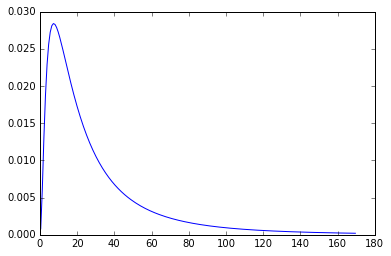

In [4]:
fig, ax = plt.subplots()
ax.plot(w_vec, p_vec)
plt.show()

Let's make a default model to play with

In [5]:
c = 10
T = 0
mcm = McCallModel(alpha=alpha_q, 
         beta=beta, 
         gamma=gamma, 
         c=c-T,         # post tax compensation
         sigma=sigma, 
         w_vec=w_vec-T, # post tax wages
         p_vec=p_vec)

In [6]:
w_bar = compute_reservation_wage(mcm)

In [7]:
w_bar

31.875

In [9]:
def compute_optimal_quantities(c, T):
    """
    Compute the reservation wage, job finding rate and value functions of the workers 
    given c and T.

    """
    
    mcm = McCallModel(alpha=alpha_q, 
                     beta=beta, 
                     gamma=gamma, 
                     c=c-T,         # post tax compensation
                     sigma=sigma, 
                     w_vec=w_vec-T, # post tax wages
                     p_vec=p_vec)

    w_bar, V, U = compute_reservation_wage(mcm, return_values=True)
    lmda = gamma * np.sum(p_vec[w_vec-T > w_bar])
    return w_bar, lmda, V, U

In [10]:
def compute_steady_state_quantities(c, T):
    """
    Compute the steady state unemployment rate given c and T using optimal
    quantities from the McCall model and computing corresponding steady state
    quantities

    """
    w_bar, lmda, V, U = compute_optimal_quantities(c, T)
    
    # Compute steady state employment and unemployment rates
    lm = LakeModel(alpha=alpha_q, lmda=lmda, b=0, d=0) 
    x = lm.rate_steady_state()
    e, u = x
    
    # Compute steady state welfare
    w = np.sum(V * p_vec * (w_vec - T > w_bar)) / np.sum(p_vec * (w_vec - T > w_bar))
    welfare = e * w + u * U
    
    return e, u, welfare

In [18]:
def find_balanced_budget_tax(c):
    """
    Find the smallest tax that will induce a balanced budget

    """
    def steady_state_budget(t):
        e, u, w = compute_steady_state_quantities(c, t)
        return t - u * c

    T = brentq(steady_state_budget, 0.0, 0.9 * c)
    return T

In [19]:
find_balanced_budget_tax(10)

1.09115088293371

In [20]:
find_balanced_budget_tax(50)

14.578956434859982

Now step through all c values to be considered.  At each one, find budget
balancing T, and then evaluate endogenous quantities at these values.  
Plot the values against c.

In [24]:
tax_vec = []
unempl_vec = []
empl_vec = []
welfare_vec = []

for c in c_vec:
    t = find_balanced_budget_tax(c)
    e_rate, u_rate, welfare = compute_steady_state_quantities(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(e_rate)
    welfare_vec.append(welfare)

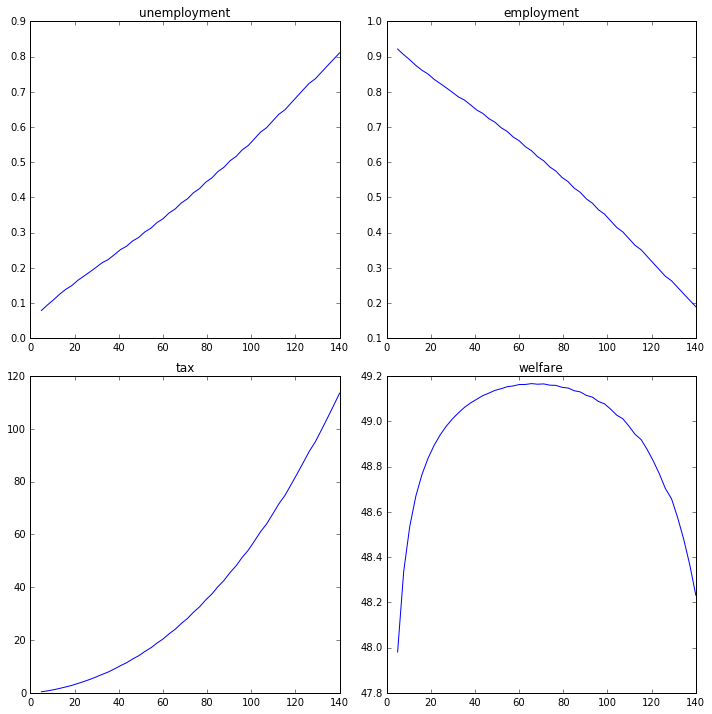

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

ax = axes[0, 0]
ax.plot(c_vec, unempl_vec)
ax.set_title('unemployment')

ax = axes[0, 1]
ax.plot(c_vec, empl_vec)
ax.set_title('employment')

ax = axes[1, 0]
ax.plot(c_vec, tax_vec)
ax.set_title('tax')

ax = axes[1, 1]
ax.plot(c_vec, welfare_vec)
ax.set_title('welfare')

plt.tight_layout()
plt.show()